In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np

resultsPath = Path("../results/MPI_2.csv")


In [2]:
dataFrame = pd.read_csv(resultsPath)
dataFrame["problemSize"] = dataFrame["problemSize"].astype(int)
dataFrame["numProcesses"] = dataFrame["numProcesses"].astype(int)
dataFrame["timeSeconds"] = dataFrame["timeSeconds"].astype(float)
dataFrame["runIndex"] = dataFrame["runIndex"].astype(int)

print("Loaded rows:", len(dataFrame))
print("Problem sizes:", sorted(dataFrame["problemSize"].unique()))
print("Process counts:", sorted(dataFrame["numProcesses"].unique()))
dataFrame.head(8)


Loaded rows: 105
Problem sizes: [1000000, 5000000, 10000000]
Process counts: [1, 2, 4, 6, 8, 16, 32]


,testType,problemSize,numProcesses,timeSeconds,dotProduct,runIndex,mpiEnv
0,MPI_2,1000000,1,0.006281,249824.938857,4,SLURM_NTASKS=1;JOBID=12958
1,MPI_2,1000000,1,0.006327,250177.827422,3,SLURM_NTASKS=1;JOBID=12957
2,MPI_2,1000000,1,0.006385,249822.023111,1,SLURM_NTASKS=1;JOBID=12955
3,MPI_2,1000000,1,0.006326,250046.350547,2,SLURM_NTASKS=1;JOBID=12956
4,MPI_2,1000000,2,0.006480,249542.852832,2,SLURM_NTASKS=2;JOBID=12961
5,MPI_2,1000000,1,0.006519,250161.752379,5,SLURM_NTASKS=1;JOBID=12959
6,MPI_2,1000000,2,0.006335,250427.944860,3,SLURM_NTASKS=2;JOBID=12962
7,MPI_2,1000000,2,0.006421,249915.250453,1,SLURM_NTASKS=2;JOBID=12960


In [3]:
groupedFrame = dataFrame.groupby(["problemSize","numProcesses"], as_index=False).agg(
    median=("timeSeconds","median"),
    mean=("timeSeconds","mean"),
    std=("timeSeconds","std"),
    count=("timeSeconds","count")
)
groupedFrame["std"] = groupedFrame["std"].fillna(0.0)
groupedFrame = groupedFrame.sort_values(["problemSize","numProcesses"]).reset_index(drop=True)
groupedFrame.head(12)


,problemSize,numProcesses,median,mean,std,count
0,1000000,1,0.006327,0.006368,0.000092,5
1,1000000,2,0.006422,0.006419,0.000053,5
2,1000000,4,0.009396,0.009416,0.000751,5
3,1000000,6,0.013489,0.012557,0.002191,5
4,1000000,8,0.012470,0.012179,0.000871,5
5,1000000,16,0.016741,0.016826,0.001407,5
6,1000000,32,0.153179,0.153345,0.002555,5
7,5000000,1,0.031201,0.031194,0.000159,5
8,5000000,2,0.029500,0.029899,0.000721,5
9,5000000,4,0.030606,0.030641,0.000463,5


In [4]:
def computeSpeedupEfficiency(groupedDf):
    frames = []
    for problemSizeVal, subFrame in groupedDf.groupby("problemSize"):
        baseRows = subFrame[subFrame["numProcesses"] == 1]
        if baseRows.empty:
            continue
        baseTime = float(baseRows["median"].values[0])
        subFrame = subFrame.copy()
        subFrame["speedup"] = baseTime / subFrame["median"]
        subFrame["efficiency"] = subFrame["speedup"] / subFrame["numProcesses"]
        frames.append(subFrame)
    if not frames:
        return pd.DataFrame()
    return pd.concat(frames, ignore_index=True)

perfFrame = computeSpeedupEfficiency(groupedFrame)
perfFrame.head(12)


,problemSize,numProcesses,median,mean,std,count,speedup,efficiency
0,1000000,1,0.006327,0.006368,0.000092,5,1.000000,1.000000
1,1000000,2,0.006422,0.006419,0.000053,5,0.985207,0.492604
2,1000000,4,0.009396,0.009416,0.000751,5,0.673372,0.168343
3,1000000,6,0.013489,0.012557,0.002191,5,0.469049,0.078175
4,1000000,8,0.012470,0.012179,0.000871,5,0.507378,0.063422
5,1000000,16,0.016741,0.016826,0.001407,5,0.377934,0.023621
6,1000000,32,0.153179,0.153345,0.002555,5,0.041305,0.001291
7,5000000,1,0.031201,0.031194,0.000159,5,1.000000,1.000000
8,5000000,2,0.029500,0.029899,0.000721,5,1.057661,0.528831
9,5000000,4,0.030606,0.030641,0.000463,5,1.019441,0.254860


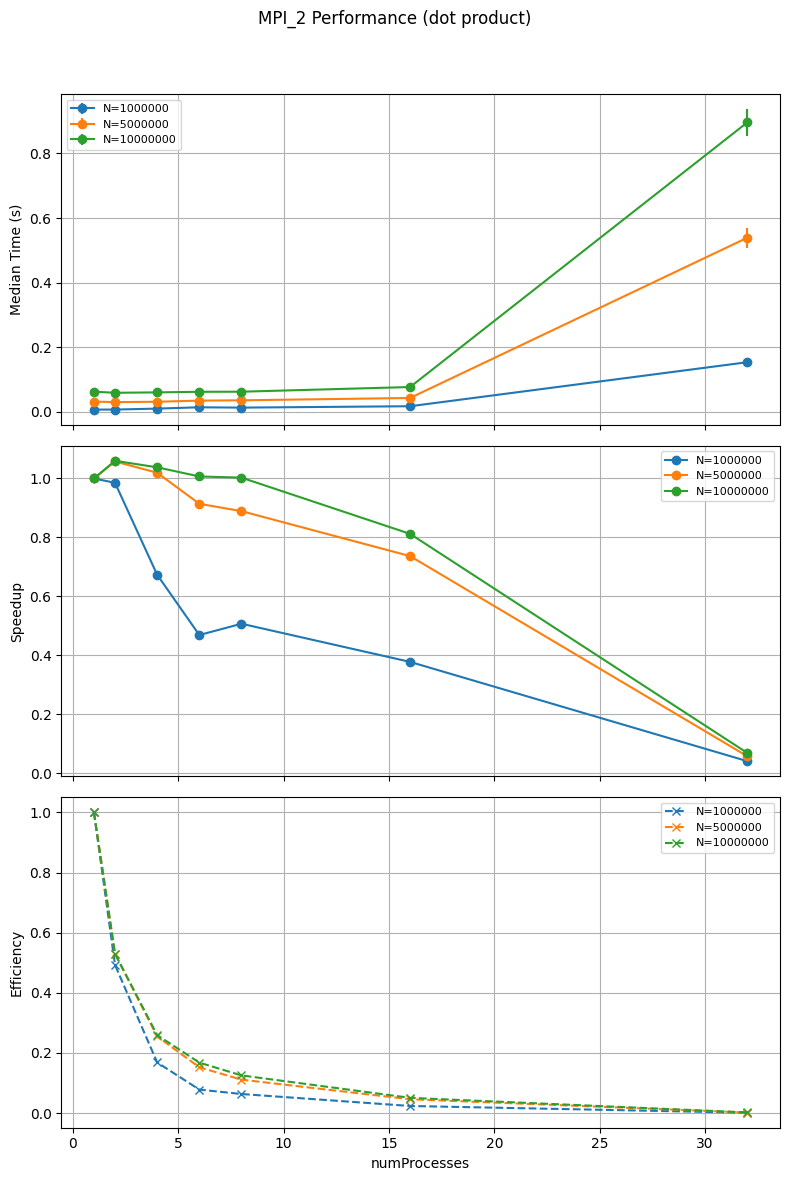

In [5]:
metrics = ["median", "speedup", "efficiency"]
metricLabels = {"median":"Median Time (s)", "speedup":"Speedup", "efficiency":"Efficiency"}

problemSizeList = sorted(perfFrame["problemSize"].unique())
processList = sorted(perfFrame["numProcesses"].unique())

fig, axes = plt.subplots(len(metrics), 1, figsize=(8, 12), sharex=True)
if len(metrics) == 1:
    axes = [axes]

for rowIdx, metric in enumerate(metrics):
    ax = axes[rowIdx]
    for problemSizeVal in problemSizeList:
        subFrame = perfFrame[perfFrame["problemSize"] == problemSizeVal].sort_values("numProcesses")
        if subFrame.empty:
            continue
        x = subFrame["numProcesses"].values
        y = subFrame[metric].values
        if metric == "median":
            yerr = subFrame["std"].values
            ax.errorbar(x, y, yerr=yerr, marker='o', linestyle='-', label=f"N={problemSizeVal}")
        else:
            linestyle = '-' if metric == 'speedup' else '--'
            markerStyle = 'o' if metric == 'speedup' else 'x'
            ax.plot(x, y, marker=markerStyle, linestyle=linestyle, label=f"N={problemSizeVal}")
    ax.set_ylabel(metricLabels[metric])
    ax.grid(True)
    ax.legend(fontsize=8)

axes[-1].set_xlabel('numProcesses')
plt.suptitle('MPI_2 Performance (dot product)')
plt.tight_layout(rect=[0,0,1,0.95])
plt.show()


In [6]:
display(perfFrame.pivot_table(index="numProcesses", columns="problemSize", values="median"))
summaryRows = []
for problemSizeVal, sub in perfFrame.groupby("problemSize"):
    maxSpeedup = sub["speedup"].max()
    argMax = sub.loc[sub["speedup"].idxmax()]
    bestProcs = int(argMax["numProcesses"])
    effAtBest = float(argMax["efficiency"])
    medianAtOne = sub.loc[sub["numProcesses"]==1, "median"]
    medianAtOne = float(medianAtOne.values[0]) if not medianAtOne.empty else np.nan
    summaryRows.append({
        "problemSize": problemSizeVal,
        "bestNumProcesses": bestProcs,
        "maxSpeedup": maxSpeedup,
        "efficiencyAtBest": effAtBest,
        "medianTime1Process": medianAtOne
    })

summaryFrame = pd.DataFrame(summaryRows).sort_values("problemSize")
display(summaryFrame)


problemSize,1000000,5000000,10000000
numProcesses,,,
1,0.006327,0.031201,0.061937
2,0.006422,0.029500,0.058440
4,0.009396,0.030606,0.059679
6,0.013489,0.034136,0.061517
8,0.012470,0.035087,0.061764
16,0.016741,0.042352,0.076265
32,0.153179,0.538970,0.896390


,problemSize,bestNumProcesses,maxSpeedup,efficiencyAtBest,medianTime1Process
0,1000000,1,1.000000,1.000000,0.006327
1,5000000,2,1.057661,0.528831,0.031201
2,10000000,2,1.059839,0.529920,0.061937
